In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

In [2]:
class LinearVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(1, 1)
        self.mu_coder = nn.Linear(1, 1)
        self.var_coder = nn.Linear(1, 1)
        self.decoder = nn.Linear(1, 1)

    def encode(self, X):
        code = self.encoder(X)
        return self.mu_coder(code), self.var_coder(code)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, Z):
        return self.decoder(Z)

    def forward(self, X):
        mu, log_var = self.encode(X)
        Z = self.reparameterize(mu, log_var)
        return self.decode(Z), mu, log_var

    def reconstruct(self, X):
        mu, _ = self.encode(X)
        return self.decode(mu)

    def sample(self, Z):
        return self.decode(Z)


vae = LinearVAE()

In [3]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

## KLD and BCE

In [39]:
model = vae.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=20, verbose=False, threshold=1e-3)

In [40]:
KLDLoss = []
L2Losss = []
encoderWeight = []
muWeight = []
varWeight = []
decoderWeight = []
encoderBias = []
muBias = []
varBias = []
decoderBias = []


def train(model, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(range(100), unit='batch') as tEpoch:
        for _ in tEpoch:
            encoderWeight.append(model.encoder._parameters['weight'].item())
            muWeight.append(model.mu_coder._parameters['weight'].item())
            varWeight.append(model.var_coder._parameters['weight'].item())
            decoderWeight.append(model.decoder._parameters['weight'].item())
            encoderBias.append(model.encoder._parameters['bias'].item())
            muBias.append(model.mu_coder._parameters['bias'].item())
            varBias.append(model.var_coder._parameters['bias'].item())
            decoderBias.append(model.decoder._parameters['bias'].item())
            X = torch.randn((64, 1)).to(dtype=torch.float32, device='cuda')
            optimizer.zero_grad()
            output, mu, log_var = model(X)
            reconLoss = L2Loss(output, X)
            divergeLoss = KLD(mu, log_var)
            KLDLoss.append(divergeLoss.item())
            L2Losss.append(reconLoss.item())
            loss = divergeLoss + reconLoss
            loss.backward()
            optimizer.step()
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.8f}\tReconstruction Loss: {:.8f}\t lr: {:.12f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [41]:
for epoch in range(1, 1001):
    allLoss, loss = train(model, optimizer, epoch)
    scheduler.step(np.mean(loss))

100%|██████████| 100/100 [00:00<00:00, 278.26batch/s,  Epoch: 1000 	Total Loss: 0.68889272	Reconstruction Loss: 0.39048338	 lr: 0.000000010000]


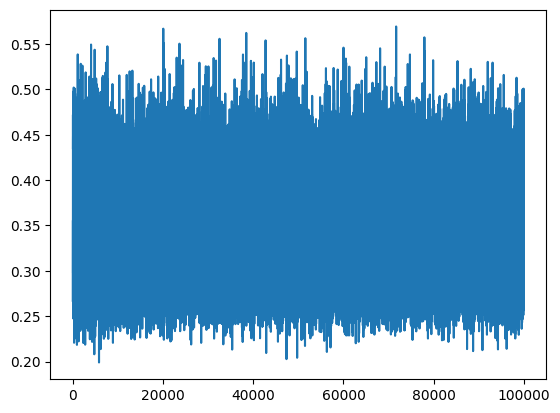

In [43]:
plt.plot(KLDLoss)

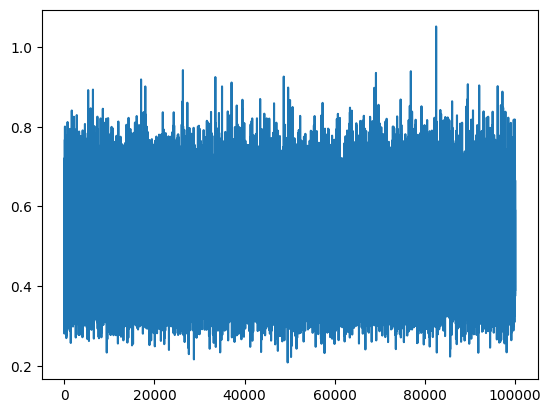

In [44]:
plt.plot(L2Losss)

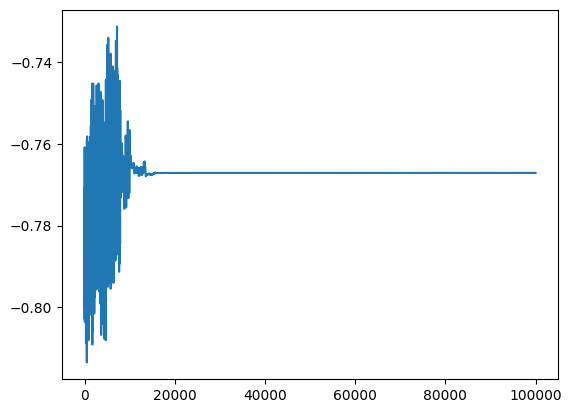

In [45]:
plt.plot(muWeight)

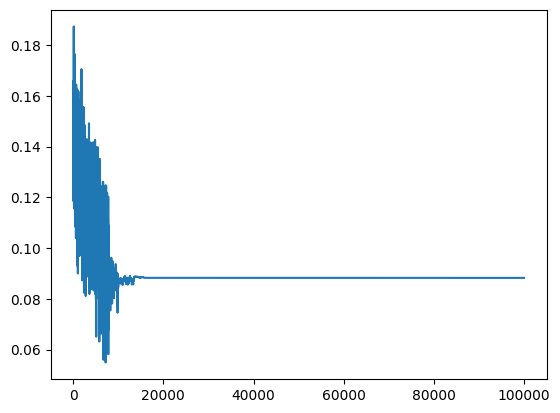

In [46]:
plt.plot(muBias)

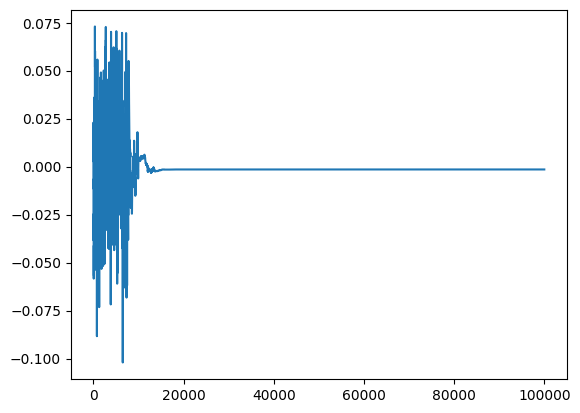

In [47]:
plt.plot(varWeight)

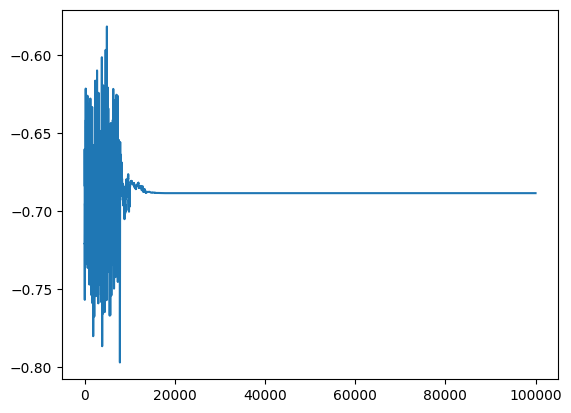

In [48]:
plt.plot(varBias)

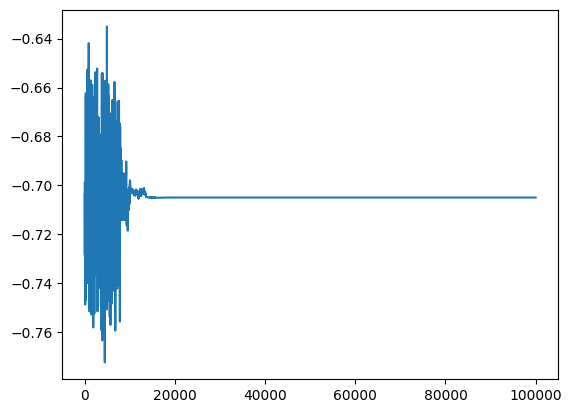

In [49]:
plt.plot(decoderWeight)

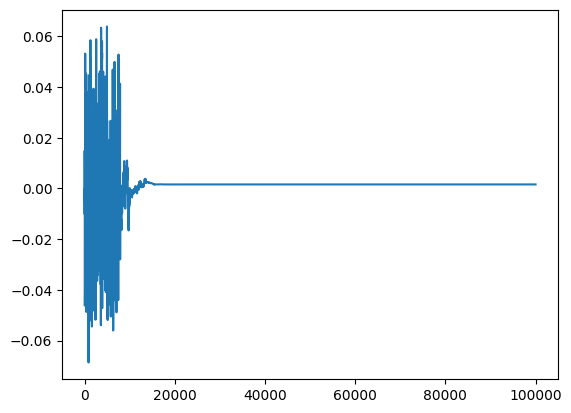

In [50]:
plt.plot(decoderBias)

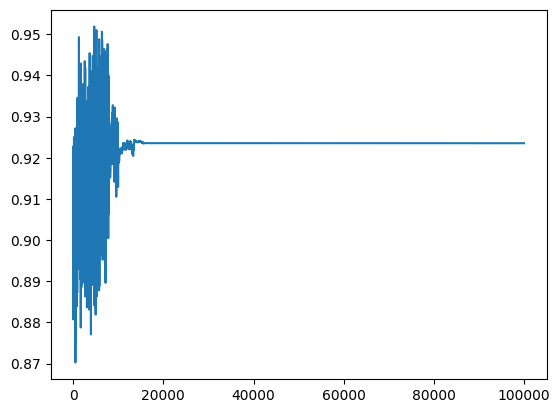

In [51]:
plt.plot(encoderWeight)

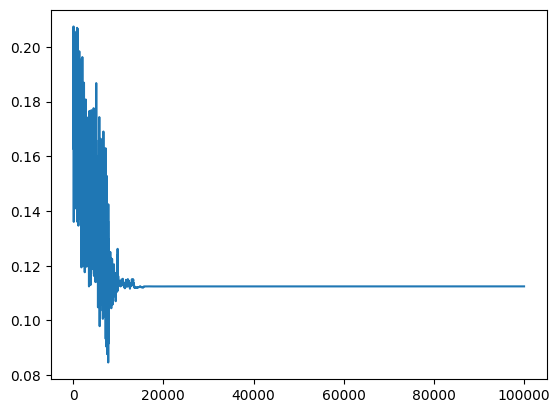

In [52]:
plt.plot(encoderBias)